In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime as datetime
import matplotlib.colors as mcolors

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import interpolate

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
ds = xr.open_dataset('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2009_2021_10min.nc')
ds['doy_sin'] = np.sin(2*np.pi*ds['doy']/365)
ds['doy_cos'] = np.cos(2*np.pi*ds['doy']/365)
#ds['Bt'] = np.sqrt(ds['BX_GSE']**2 + ds['BY_GSE']**2 + ds['BZ_GSE']**2)
#s['mlt_sin'] = np.sin(2*np.pi*ds['mlt']/24)
#ds['mlt_cos'] = np.cos(2*np.pi*ds['mlt']/24)
ds

<xarray.Dataset> Size: 6GB
Dimensions:         (dt: 635616, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 5MB 2009-12-01 ... 2021-12-31T23:50:00
  * mlat            (mlat) float64 400B 40.0 41.02 42.04 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables:
    jPar            (dt, mlat, mlt) float64 6GB ...
    BX_GSE          (dt) float64 5MB ...
    BY_GSE          (dt) float64 5MB ...
    BZ_GSE          (dt) float64 5MB ...
    flow_speed      (dt) float64 5MB ...
    proton_density  (dt) float64 5MB ...
    F10.7           (dt) float64 5MB ...
    Kp              (dt) float64 5MB ...
    doy             (dt) float64 5MB 335.0 335.0 335.0 ... 365.0 365.0 365.0
    doy_sin         (dt) float64 5MB -0.4938 -0.4938 ... 6.432e-16 6.432e-16
    doy_cos         (dt) float64 5MB 0.8696 0.8696 0.8696 0.8696 ... 1.0 1.0 1.0

In [5]:
def clock_angle(By, Bz):
    angle = np.rad2deg(np.arctan2(By, Bz))
    np.where(angle < 0, angle + 360, angle)
    return angle

def cross_polar_cap_pot(v_sw,By, Bz):
    #Not in SI units
    #from https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/96JA01742
    #and  https://www.sws.bom.gov.au/Category/Solar/Solar%20Conditions/Solar%20Wind%20Clock%20Angle/Solar%20Wind%20Clock%20Angle.php

    theta  = clock_angle(By, Bz)
    B_L = np.sqrt(By**2 + Bz**2)

    CPCP = 10e-4 * v_sw**2 + 11.7 * B_L * (np.sin(np.deg2rad(theta)/2))**3

    return CPCP

ds['CPCP'] = cross_polar_cap_pot(ds['flow_speed'],  ds['BY_GSE'], ds['BZ_GSE'])
ds

<xarray.Dataset> Size: 6GB
Dimensions:         (dt: 635616, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 5MB 2009-12-01 ... 2021-12-31T23:50:00
  * mlat            (mlat) float64 400B 40.0 41.02 42.04 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables:
    jPar            (dt, mlat, mlt) float64 6GB ...
    BX_GSE          (dt) float64 5MB ...
    BY_GSE          (dt) float64 5MB 0.97 1.635 1.6 1.745 ... 2.8 3.085 2.19
    BZ_GSE          (dt) float64 5MB -0.02 -0.01 -0.38 ... -3.25 -4.465 -5.41
    flow_speed      (dt) float64 5MB 275.5 276.5 275.0 ... 396.5 396.0 399.0
    proton_density  (dt) float64 5MB ...
    F10.7           (dt) float64 5MB ...
    Kp              (dt) float64 5MB ...
    doy             (dt) float64 5MB 335.0 335.0 335.0 ... 365.0 365.0 365.0
    doy_sin         (dt) float64 5MB -0.4938 -0.4938 ... 6.432e-16 6.432e-16
    doy_cos         (dt) float64 5MB 0.8696 0.8696 0.8696 0.8696 ... 1.0 1.0 1.0
    CPCP            (dt) float64 5MB 80.04 83.28 84.92 ... 198.6 212.1 223.8

In [6]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, nan_count, np.round(nan_ratio, 2)

#nan_count(ds, 'jPar')

In [7]:
# Initialize scalers for the target variable and input variables
input_scaler = StandardScaler()

# Extract the target variable and reshape for scaling
target_var = ds['jPar'].values  # shape (t (n), mlat (50), mlt (24))

# Extract and scale input variables (variables that are dependent only on 'dt')
input_vars = ['BX_GSE', 'BY_GSE', 'BZ_GSE', 'flow_speed', 'proton_density', 'F10.7', 'doy_sin','doy_cos']
input_data = np.array([ds[var].values for var in input_vars]).T  # shape (22320, number_of_vars)
input_data_scaled = input_scaler.fit_transform(input_data)

file_path = f'scaler_id3.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(input_scaler, file)

def create_sequences(target_data, input_data, lookback=30):
    X, y = [], []
    for i in range(len(target_data) - lookback):
        X.append(input_data[i:i+lookback].T)
        y.append(target_data[i+lookback])

    return np.array(X), np.array(y)

lookback = 6
X, y = create_sequences(target_var, input_data_scaled, lookback=lookback)

X.shape, y.shape

((635610, 8, 6), (635610, 50, 24))

In [8]:
def simple_time_series_split(X, y, train_ratio=0.9, test_ratio=0.05):

    # Calculate split indices
    train_idx = int(len(X) * train_ratio)
    test_idx = int(len(X) * (train_ratio +test_ratio))

    # Perform the split
    X_train, X_val, X_test = X[:train_idx], X[train_idx:test_idx], X[test_idx:]
    y_train, y_val, y_test = y[:train_idx], y[train_idx:test_idx], y[test_idx:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = simple_time_series_split(X, y)
X_train.shape, X_val.shape, X_test.shape

((572049, 8, 6), (31780, 8, 6), (31781, 8, 6))

In [9]:
def random_time_series_split(X, y, segment_length, train_ratio=0.8, val_ratio=0.1):
    total_segments = len(X) // segment_length
    #total_samples = total_segments * segment_length
    
    # Shuffle indices to randomly select segments
    indices = np.arange(total_segments)
    np.random.shuffle(indices) 
    
    # Calculate sizes of train, validation, and test sets
    train_size = int(total_segments * train_ratio)
    val_size = int(total_segments * val_ratio)
    #test_size = total_segments - train_size - val_size
    
    # Select indices for train, validation, and test sets
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    # Function to extract segments
    def extract_segments(indices):
        X_segments = []
        y_segments = []
        for idx in indices:
            start_idx = idx * segment_length
            X_segment = X[start_idx:start_idx + segment_length]
            y_segment = y[start_idx:start_idx + segment_length]
            X_segments.append(X_segment)
            y_segments.append(y_segment)
        return np.concatenate(X_segments), np.concatenate(y_segments)
    
    # Extract train, validation, and test sets
    X_train, y_train = extract_segments(train_indices)
    X_val, y_val = extract_segments(val_indices)
    X_test, y_test = extract_segments(test_indices)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

segment_length = 2016 # 1 week
#segment_length = 2016 * 4 # 1 month
#segment_length = 2016 * 4 * 3 # 3 months

#X_train, y_train, X_val, y_val, X_test, y_test = random_time_series_split(X, y, segment_length)
#X_train.shape, X_val.shape, X_test.shape

In [10]:
# Convert data to PyTorch tensors and move to GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = np.array(y_test)

# Create DataLoader
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

X_train.shape, y_train.shape

(torch.Size([572049, 8, 6]), torch.Size([572049, 50, 24]))

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True) 
        
        self.fc = nn.Linear(hidden_size, 50*24)

    def forward(self, x):
        batch_size = x.size(0) # Get the batch size
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :]) # Get the last output of the LSTM
        out = out.view(-1, 50, 24) # Reshape to (batch_size, mlat, mlt)
        return out
    
    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

# Instantiate the model with lookback size
model = LSTM(lookback, 64, 2)
model.to(device)
#model

LSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1200, bias=True)
)

In [12]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True, 
                            bidirectional=True)  # Bidirectional flag
        
        # Output size for the fully connected layer is doubled due to bidirectionality
        self.fc = nn.Linear(hidden_size * 2, 256)  # Hidden size * 2 for bidirectional
        self.fc_out = nn.Linear(256, 50 * 24)  # Final output layer

    def forward(self, x):
        batch_size = x.size(0) # Get the batch size
        h0 = torch.zeros(self.num_stacked_layers * 2, batch_size, self.hidden_size).to(device)  # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers * 2, batch_size, self.hidden_size).to(device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])  # Get the last output of the LSTM
        out = self.fc_out(out)  # Fully connected layer
        out = out.view(-1, 50, 24)  # Reshape to (batch_size, mlat, mlt)
        return out

#model = BidirectionalLSTM(lookback, 64, 2)
#model.to(device)
#model

In [13]:
class LSTMWithConv(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 50 * 24)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)  # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])  # Get the last output of the LSTM
        out = out.view(-1, 1, 50, 24)  # Reshape to (batch_size, 1, mlat, mlt) for Conv2D

        out = self.conv1(out)
        out = nn.ReLU()(out)
        out = self.conv2(out)
        out = nn.ReLU()(out)
        out = self.conv3(out)
        out = nn.ReLU()(out)
        out = self.conv4(out)
        
        out = out.view(-1, 50, 24)  # Reshape to (batch_size, mlat, mlt)
        return out
    
    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

# Instantiate the model with lookback size
#model = LSTMWithConv(lookback, 64, 2)
#model.to(device)

#### Loss Function, weighted by grid area

In [14]:
def calculate_delta(lat1, lon1, lat2, lon2):
    radius = 6371.008

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    delta_x = dlat * radius #111.32 km per degree
    delta_y = dlon * radius * np.cos(np.radians(lat1)) 
    
    return delta_x, delta_y

areas = np.zeros((49, 23))
mlat = np.linspace(40, 90,50) #50 intervals between 40° to 90°
mlt = np.linspace(0,360,24) #24 intervals between 0° to 360°

for i in range(len(mlat) - 1):
    for j in range(len(mlt) - 1):
        lat1, lat2 = mlat[i], mlat[i + 1]
        lon1, lon2 = mlt[j], mlt[j + 1]
        
        delta_x, delta_y = calculate_delta(lat1, lon1, lat2, lon2)
        
        area = delta_x * delta_y
        areas[i, j] = area


def weighted_loss_function(y_true, y_pred):
    #weights = np.log2(areas)*2

    # Normalize the area
    weights = areas / np.sum(areas)

    # Interpolate the weights and match the 50 x 24 shape
    x = np.arange(weights.shape[1])
    y = np.arange(weights.shape[0])
    f = interpolate.interp2d(x, y, weights, kind='linear')
    xnew = np.arange(0, weights.shape[1], weights.shape[1]/(weights.shape[1]+1))
    ynew = np.arange(0, weights.shape[0], weights.shape[0]/(weights.shape[0]+1))
    weights = f(xnew, ynew)
   
    #weights = np.flipud(weights)
    weights = np.copy(weights) #some bug in the code, so copying the weights
    
    #matrix multiply the weights with the absolute difference between true and predicted values
    loss = torch.mean(torch.abs(y_true - y_pred) * torch.tensor(weights, dtype=torch.float32).to(device))
    loss = loss * 1e3 # rescaling the loss

    return loss

In [15]:
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=7e-4)
scheduler = StepLR(optimizer, step_size=8, gamma=0.7)

In [16]:
# Train the model
num_epochs = 50
train_losses = []
val_losses = []

# Early stopping
best_val_loss = float('inf')
patience = 7
counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Forward pass
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        train_outputs = model(X_batch)
        #loss = loss_function(train_outputs, y_batch)
        loss = weighted_loss_function(y_batch, train_outputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            #val_loss += loss_function(val_outputs, y_batch).item()
            val_loss += weighted_loss_function(y_batch, val_outputs).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_lstm_model.pt')
    else:
        counter += 1
        if counter == patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping training.')
            break

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss (MAE): {train_loss:.4f}, Val Loss (MAE): {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.1e}')

best_model = LSTM(lookback, 64, 2)
best_model.load_state_dict(torch.load('best_lstm_model.pt'))
best_model.to(device)

/tmp/ipykernel_60668/66453493.py:35: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, weights, kind='linear')
/tmp/ipykernel_60668/66453493.py:38: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` 

Epoch [1/50], Train Loss (MAE): 0.0632, Val Loss (MAE): 0.0555, Best Val Loss: 0.0555, LR: 7.0e-04
Epoch [2/50], Train Loss (MAE): 0.0620, Val Loss (MAE): 0.0533, Best Val Loss: 0.0533, LR: 7.0e-04
Epoch [3/50], Train Loss (MAE): 0.0601, Val Loss (MAE): 0.0512, Best Val Loss: 0.0512, LR: 7.0e-04
Epoch [4/50], Train Loss (MAE): 0.0596, Val Loss (MAE): 0.0510, Best Val Loss: 0.0510, LR: 7.0e-04
Epoch [5/50], Train Loss (MAE): 0.0594, Val Loss (MAE): 0.0514, Best Val Loss: 0.0510, LR: 7.0e-04
Epoch [6/50], Train Loss (MAE): 0.0592, Val Loss (MAE): 0.0512, Best Val Loss: 0.0510, LR: 7.0e-04
Epoch [7/50], Train Loss (MAE): 0.0591, Val Loss (MAE): 0.0519, Best Val Loss: 0.0510, LR: 7.0e-04
Epoch [8/50], Train Loss (MAE): 0.0590, Val Loss (MAE): 0.0522, Best Val Loss: 0.0510, LR: 4.9e-04
Epoch [9/50], Train Loss (MAE): 0.0590, Val Loss (MAE): 0.0515, Best Val Loss: 0.0510, LR: 4.9e-04
Epoch [10/50], Train Loss (MAE): 0.0589, Val Loss (MAE): 0.0506, Best Val Loss: 0.0506, LR: 4.9e-04
Epoch [11

LSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1200, bias=True)
)

### Make Predictions

In [17]:
with torch.no_grad():
     predictions = best_model(X_test).cpu().numpy()
predictions.shape

(31781, 50, 24)

### Calulate Global Scores

In [18]:
RMSE = np.sqrt(np.mean((y_test - predictions)**2))
NRMSE = RMSE / (np.max(y_test) - np.min(y_test))
MAE = np.mean(np.abs(y_test - predictions))
R = np.corrcoef(y_test.flatten(), predictions.flatten())[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / np.sum((o - np.mean(o))**2))
    return skill      

PE = skill(predictions, y_test)

print(f'Test Loss (RMSE): {RMSE:.4f}, Test Loss (NRMSE): {NRMSE:.4f}, Test Loss (MAE): {MAE:.4f}, R: {R:.4f}, Skill: {PE:.4f}')

Test Loss (RMSE): 0.1109, Test Loss (NRMSE): 0.0152, Test Loss (MAE): 0.0629, R: 0.6001, Skill: 0.3591


### Plot Training and Validation Curves

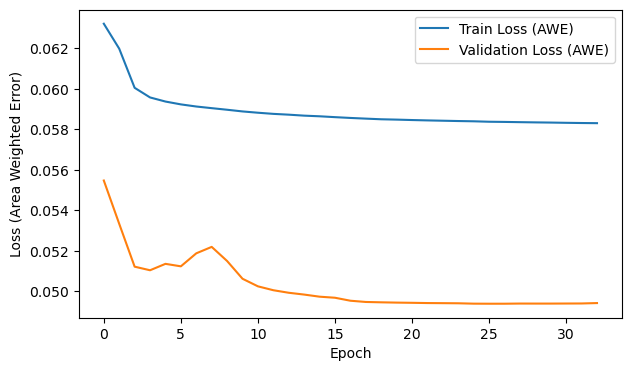

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
plt.plot(train_losses, label='Train Loss (AWE)')
plt.plot(val_losses, label='Validation Loss (AWE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Area Weighted Error)')
plt.legend()

### Daily Predictions

In [82]:
def open_multiple_nc(nc_files):
    ds = xr.open_mfdataset(nc_files, concat_dim='dt', combine='nested', parallel=True)
    ds['doy_sin'] = np.sin(2*np.pi*ds['doy']/365)
    ds['doy_cos'] = np.cos(2*np.pi*ds['doy']/365)

    #average over 5min
    ds = ds.resample(dt='10min').mean()
    #ds = ds.interpolate_na(dim='dt')

    #ds = ds.sel(nRec=slice(16500, 17000))

    return ds

dir = '/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/excluded/*.nc'
open_multi_amp = open_multiple_nc(dir)
open_multi_amp

<xarray.Dataset> Size: 1MB
Dimensions:         (mlat: 50, mlt: 24, dt: 144)
Coordinates:
  * mlat            (mlat) float64 400B 40.0 41.02 42.04 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
  * dt              (dt) datetime64[ns] 1kB 2013-05-14 ... 2013-05-14T23:50:00
Data variables: (12/15)
    jPar            (dt, mlat, mlt) float64 1MB dask.array<chunksize=(1, 50, 24), meta=np.ndarray>
    BX_GSE          (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    BY_GSE          (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    BZ_GSE          (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    flow_speed      (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    proton_density  (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    ...              ...
    ASY_H           (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    F10.7           (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    Kp              (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    doy             (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    doy_sin         (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    doy_cos         (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>

In [83]:
def split_to_df(ds):
    ds = ds.copy()

    dt = ds['dt'].values.flatten()
    BX_GSE = ds['BX_GSE'].values.flatten() #1
    BY_GSE = ds['BY_GSE'].values.flatten() #2
    BZ_GSE = ds['BZ_GSE'].values.flatten() #3
    flow_speed = ds['flow_speed'].values.flatten() #4
    proton_density = ds['proton_density'].values.flatten() #5
    doy_sin = ds['doy_sin'].values.flatten() #6
    doy_cos = ds['doy_cos'].values.flatten() #7
    
    #AL_INDEX = ds['AL_INDEX'].values.flatten() #6
    #AU_INDEX = ds['AU_INDEX'].values.flatten() #7
    #SYM_H = ds['SYM_H'].values.flatten() #8
    #ASY_H = ds['ASY_H'].values.flatten()  #9
    F10_7 = ds['F10.7'].values.flatten() #10
    #Kp = ds['Kp'].values.flatten() #11

    #return BX_GSE.shape

    df_dict = {'dt':dt, 'BX_GSE': BX_GSE, 'BY_GSE': BY_GSE, 'BZ_GSE': BZ_GSE, 'flow_speed': flow_speed, 'proton_density': proton_density,'F10.7': F10_7, 'doy_sin': doy_sin, 'doy_cos': doy_cos}

    df = pd.DataFrame(df_dict)
    
    df_2 = df.copy()
    df_2 = df_2.drop(columns=['dt'])

    return df, df_2

split_to_df(open_multi_amp)
df_raw, df_proc = split_to_df(open_multi_amp)
col_names = df_raw.columns

In [84]:
norm_arr = input_scaler.transform(df_proc)

def create_sequences(arr, lookback=lookback):
    X = []
    for i in range(len(arr) - lookback):
        X.append(arr[i:i+lookback].T)

    X = np.array(X)

    return X

proc_seq = create_sequences(norm_arr)
raw_seq = create_sequences(df_raw.values)

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [85]:
# Assuming best_model is already defined and loaded
device = torch.device('cpu')
best_model.to(device)  # Ensure the model is on the CPU
best_model.eval()

# Adjust the shape to match the model's expected input size
norm_proc = torch.tensor(proc_seq, dtype=torch.float32).to(device)
norm_proc = norm_proc.permute(0, 1, 2)  # Change from [848370, 11, 30] to [848370, 30, 11]

predictions_daily = []

with torch.no_grad():
    for i in range(len(norm_proc)):
        output = best_model(norm_proc[i].unsqueeze(0))
        predictions_daily.append(output)

predictions_daily = torch.cat(predictions_daily)
predictions_daily = predictions_daily.numpy()  # Tensor is already on CPU, no need to move again

In [86]:
ds = xr.Dataset({'Jpar_pred': (['dt', 'mlat', 'mlt'], predictions_daily),
                 'Jpar_true': (['dt', 'mlat', 'mlt'], open_multi_amp['jPar'].values[lookback:]),
                 'BX_GSE': (['dt'], open_multi_amp['BX_GSE'].values[lookback:]),
                  'BY_GSE': (['dt'], open_multi_amp['BY_GSE'].values[lookback:]),
                    'BZ_GSE': (['dt'], open_multi_amp['BZ_GSE'].values[lookback:]),
                    'flow_speed': (['dt'], open_multi_amp['flow_speed'].values[lookback:]),
                    'proton_density': (['dt'], open_multi_amp['proton_density'].values[lookback:]),
                 },
                coords = {'dt': df_raw['dt'].values[lookback:], 'mlat': np.arange(40, 90, 1), 'mlt': np.arange(0, 24, 1)})
ds

<xarray.Dataset> Size: 2MB
Dimensions:         (dt: 138, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 1kB 2013-05-14T01:00:00 ... 2013-05-1...
  * mlat            (mlat) int64 400B 40 41 42 43 44 45 46 ... 84 85 86 87 88 89
  * mlt             (mlt) int64 192B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
Data variables:
    Jpar_pred       (dt, mlat, mlt) float32 662kB 0.03416 0.01322 ... -0.007952
    Jpar_true       (dt, mlat, mlt) float64 1MB 0.104 -0.09871 ... -0.05456
    BX_GSE          (dt) float64 1kB 3.258 1.508 2.345 ... -4.794 -5.127 -6.225
    BY_GSE          (dt) float64 1kB 0.708 -3.454 -2.594 ... 3.589 2.616 2.583
    BZ_GSE          (dt) float64 1kB 2.251 1.013 1.63 1.9 ... 5.501 6.371 5.538
    flow_speed      (dt) float64 1kB 370.4 361.0 365.2 ... 334.6 337.0 334.0
    proton_density  (dt) float64 1kB 8.861 8.996 9.149 ... 12.1 11.11 10.02

In [87]:
timestep = 39 #10 mins
#timestep = 210 #10 mins

R = np.corrcoef(ds['Jpar_pred'].isel(dt=timestep).values, ds['Jpar_true'].isel(dt=timestep).values)[1,0]
RMSE = np.sqrt(np.mean((ds['Jpar_pred'].isel(dt=timestep).values - ds['Jpar_true'].isel(dt=timestep).values)**2))
MAE = np.mean(np.abs(ds['Jpar_pred'].isel(dt=timestep).values - ds['Jpar_true'].isel(dt=timestep).values))
NRMSE = RMSE / (np.max(ds['Jpar_true'].isel(dt=timestep).values) - np.min(ds['Jpar_true'].isel(dt=timestep).values))

print(f'R: {R:.3f}, RMSE: {RMSE:.3f}, NRMSE: {NRMSE:.3f}, MAE: {MAE:.3f}')
ds.isel(dt=timestep)

R: -0.210, RMSE: 0.116, NRMSE: 0.063, MAE: 0.080


<xarray.Dataset> Size: 15kB
Dimensions:         (mlat: 50, mlt: 24)
Coordinates:
    dt              datetime64[ns] 8B 2013-05-14T07:30:00
  * mlat            (mlat) int64 400B 40 41 42 43 44 45 46 ... 84 85 86 87 88 89
  * mlt             (mlt) int64 192B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
Data variables:
    Jpar_pred       (mlat, mlt) float32 5kB -0.0355 -0.0324 ... -0.01092
    Jpar_true       (mlat, mlt) float64 10kB 0.06174 0.1 ... -0.01888 -0.03599
    BX_GSE          float64 8B 0.036
    BY_GSE          float64 8B -3.944
    BZ_GSE          float64 8B -3.523
    flow_speed      float64 8B 362.8
    proton_density  float64 8B 9.131

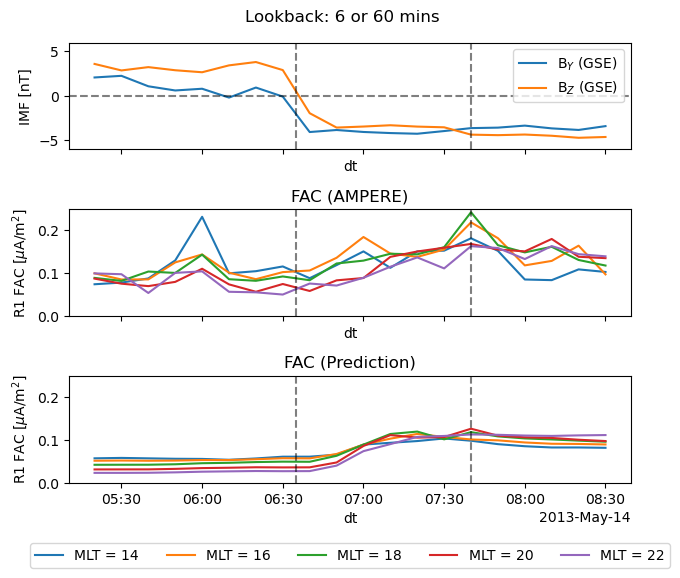

In [111]:
#linepllot of Jpat true across all mlat and mlt at a given timestep with dt as x-axis

def plot_line(ds):
    ds = ds.copy()

    fig, ax = plt.subplots(3,1,figsize=(7, 6), sharex=True, sharey=False)
    ds = ds.sel(dt=slice('2013-05-14T05:15:00', '2013-05-14T08:30:00'))
    ds = ds.sel(mlt=slice(14,23))
    ds = ds.sel(mlat=slice(65,78))

    ds['Jpar_true_abs'] = np.abs(ds['Jpar_true'])
    ds['Jpar_pred_abs'] = np.abs(ds['Jpar_pred'])

    ds['BY_GSE'].plot(ax=ax[0], label='BY_GSE')
    ds['BZ_GSE'].plot(ax=ax[0], label='BZ_GSE')
    ax[0].legend(loc='upper right')
    ax[0].set_ylim(-6, 6)
    ax[0].set_ylabel(f'IMF [nT]')
    #change labels in legend
    ax[0].legend(['B$_{Y}$ (GSE)', 'B$_{Z}$ (GSE)'])


    ds['Jpar_true_abs'].isel(mlt=0).mean(dim='mlat').plot(ax=ax[1], label='MLT = 14')
    ds['Jpar_true_abs'].isel(mlt=2).mean(dim='mlat').plot(ax=ax[1], label='MLT = 16')
    ds['Jpar_true_abs'].isel(mlt=4).mean(dim='mlat').plot(ax=ax[1], label='MLT = 18')
    ds['Jpar_true_abs'].isel(mlt=6).mean(dim='mlat').plot(ax=ax[1], label='MLT = 20')
    ds['Jpar_true_abs'].isel(mlt=8).mean(dim='mlat').plot(ax=ax[1], label='MLT = 22')
    ax[1].set_title('FAC (AMPERE)')
    fac_units = r'$\mu$A/m$^2$'
    ax[1].set_ylabel(f'R1 FAC [{fac_units}]')
    ax[1].set_ylim(0, 0.25)

    ds['Jpar_pred_abs'].isel(mlt=0).mean(dim='mlat').plot(ax=ax[2], label='MLT = 14')
    ds['Jpar_pred_abs'].isel(mlt=2).mean(dim='mlat').plot(ax=ax[2], label='MLT = 16')
    ds['Jpar_pred_abs'].isel(mlt=4).mean(dim='mlat').plot(ax=ax[2], label='MLT = 18')
    ds['Jpar_pred_abs'].isel(mlt=6).mean(dim='mlat').plot(ax=ax[2], label='MLT = 20')
    ds['Jpar_pred_abs'].isel(mlt=8).mean(dim='mlat').plot(ax=ax[2], label='MLT = 22')
    ax[2].set_title('FAC (Prediction)')
    ax[2].set_ylabel(f'R1 FAC [{fac_units}]')
    ax[2].set_ylim(0, 0.25)

    fig.suptitle(f'Lookback: 6 or 60 mins ', linespacing=1.5)    

    #add vertcal bar to all suplots at 6:00
    for i in range(3):
        ax[i].axvline(x=datetime.datetime(2013, 5, 14, 6, 35, 0), color='black', linestyle='--', alpha=0.5)

    for i in range(3):
        ax[i].axvline(x=datetime.datetime(2013, 5, 14, 7, 40, 0), color='black', linestyle='--', alpha=0.5)

    #add horiztonal line at y = 0 for subplot0
    ax[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    legend = ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), shadow=False, ncol=5)
    plt.tight_layout()
    #ax[0].grid()
    #ax[1].grid()
    #ax[2].grid()

    plt.savefig('Lookback_60_mins_LSTM.png', dpi=300)

plot_line(ds)

<>:38: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_60668/2071726237.py:38: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12,


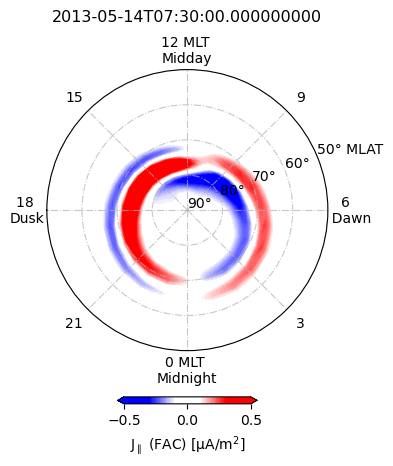

In [112]:
fac = ds['Jpar_pred'].isel(dt=timestep).values

def dt_to_str(dt):
    dt_1 = dt[0]
    dt_2 = dt[1] 
    time_1 = pd.to_datetime(dt_1)
    time_2 = pd.to_datetime(dt_2)
    str_time_1 = time_1.strftime('%Y-%m-%d %H:%M')
    str_time_2 = time_2.strftime('%Y-%m-%d %H:%M')

    return str_time_1, str_time_2

dt = ds['dt'].isel(dt=timestep).values
#start_time, end_time = dt_to_str(dt)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 90, 50) #convert to colat

cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
#cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-.5, .5, 100), extend='both')
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30,40])
ax.set_yticklabels(["90°", "80°", "70°", "60°","50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
ax.set_title(f"{dt}", pad=10, fontsize=11.5)


plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12, 
             ticks=[-0.5, 0, 0.5], 
             orientation='horizontal')

#plt.tight_layout()
plt.savefig('Lookback_60_mins_LSTM_polar_prediction.png', dpi=300, bbox_inches='tight')

<>:38: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_60668/2413123459.py:38: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12,


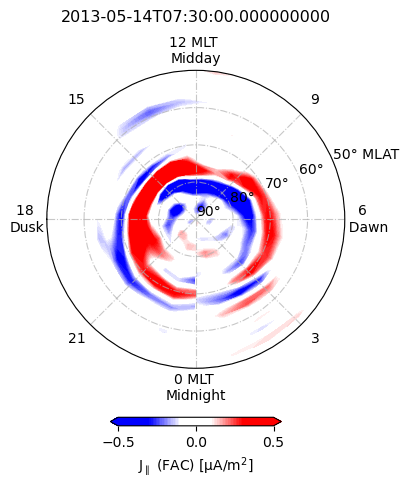

In [113]:
fac = ds['Jpar_true'].isel(dt=timestep).values

def dt_to_str(dt):
    dt_1 = dt[0]
    dt_2 = dt[1] 
    time_1 = pd.to_datetime(dt_1)
    time_2 = pd.to_datetime(dt_2)
    str_time_1 = time_1.strftime('%Y-%m-%d %H:%M')
    str_time_2 = time_2.strftime('%Y-%m-%d %H:%M')

    return str_time_1, str_time_2

dt = ds['dt'].isel(dt=timestep).values
#start_time, end_time = dt_to_str(dt)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 90, 50) #convert to colat

cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
#cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-.5, .5, 100), extend='both')
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30,40])
ax.set_yticklabels(["90°", "80°", "70°", "60°","50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
ax.set_title(f"{dt}", pad=10, fontsize=11.5)


plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12, 
             ticks=[-0.5, 0, 0.5], 
             orientation='horizontal')

plt.tight_layout()
plt.savefig('Lookback_60_mins_LSTM_polar_true.png', dpi=300, bbox_inches='tight')